In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Leemos los datos resultantes del notebook de [preprocesamiento](https://github.com/Millan13/Moneyball-NBA/blob/master/Notebooks/Integracion_data.ipynb)

In [5]:
pd.set_option('display.max_columns', 500)
filename = 'df_pairs.csv'
df_pairs = pd.read_csv(filename)
df_pairs

,Unnamed: 0,shooter,assister,team,gametype,season,count
0,0,. Abrines,A. Roberson,OKC,regular,2016-2017,6
1,1,. Abrines,C. Anthony,OKC,regular,2017-2018,8
2,2,. Abrines,C. Payne,OKC,regular,2016-2017,3
3,3,. Abrines,D. Johnson,OKC,regular,2017-2018,3
4,4,. Abrines,D. McDermott,OKC,playoff,2016-2017,1
...,...,...,...,...,...,...,...
26088,26088,Z. Williamson,J. Hayes,NOP,regular,2019-2020,1
26089,26089,Z. Williamson,J. Holiday,NOP,regular,2019-2020,32
26090,26090,Z. Williamson,J. Redick,NOP,regular,2019-2020,2
26091,26091,Z. Williamson,L. Ball,NOP,regular,2019-2020,57


In [7]:
filename2 = 'df_involvement.csv'
df_involvement = pd.read_csv(filename2)
df_involvement

,Unnamed: 0,player,team,gametype,season,shot_involvement
0,0,. Abrines,OKC,playoff,2016-2017,11
1,1,. Abrines,OKC,playoff,2017-2018,7
2,2,. Abrines,OKC,regular,2016-2017,155
3,3,. Abrines,OKC,regular,2017-2018,132
4,4,. Ak,CHI,regular,2017-2018,3
...,...,...,...,...,...,...
2867,2867,Z. Randolph,MEM,regular,2016-2017,340
2868,2868,Z. Randolph,SAC,regular,2017-2018,329
2869,2869,Z. Smith,PHI,regular,2018-2019,18
2870,2870,Z. Smith,PHI,regular,2019-2020,4


Definimos un diccionario con un color para cada equipo

In [13]:
nba_color_codes = {
    "ATL" : "#E03A3E",
    "BRK" : "#FFFFFF",
    "BOS" : "#008348", 
    "CHO" : "#008CA8",
    "CHI" : "#CE1141",
    "CLE" : "#860038", 
    "DAL" : "#20385B",
    "DEN" :  "#4FA8FF",
    "DET" :  "#006BB6", 
    "GSW" :  "#FFC72D",
    "HOU" :  "#C4CED3",
    "IND" :  "#FFC633",
    "LAC" :  "#006BB6",
    "LAL" :  "#FDB927",
    "MEM" :  "#6189B9",
    "MIA" :  "#98002E",
    "MIL" :  "#EEE1C6",
    "MIN" :  "#005083",
    "NOP" :  "#B4975A",
    "NYK" :  "#F58426",
    "OKC" :  "#007DC3",
    "ORL" :  "#007DC5",
    "PHI" :  "#ED174C",
    "PHO" :  "#1D1160",
    "POR" :  "#F0163A",
    "SAC" :  "#8E9090",
    "SAS" :  "#B6BFBF",
    "TOR" :  "#CE1141",
    "UTA" :  "#F9A01B",
    "WAS" :  "#F5002F"
}

Creamos una función que nos permite visualizar la gráfica para cada equipo, temporada y tipo de juego. Filtramos e iteramos sobre los tiros en que un par de jugadores de ese equipo se apoyaron para realizar una anotación y los añadimos como aristas.

In [23]:
def draw_network_all(team,season,game_type,df_involvement,df_pairs,size=(9,8), lw=2.5, seed=None, k=None, lc='black'):
    df_inv = df_involvement
    df_shots = df_pairs
    
    temporada_inv = df_inv['season'] == season
    df_inv = df_inv[temporada_inv]
    tipo_juego_inv = df_inv['gametype'] == game_type
    df_inv = df_inv[tipo_juego_inv]
    equipo_inv = df_inv['team'] == team
    df_inv = df_inv[equipo_inv]
    
    temporada_shot = df_shots['season'] == season
    df_shots = df_shots[temporada_shot]
    tipo_juego_shot = df_shots['gametype'] == game_type
    df_shots = df_shots[tipo_juego_shot]
    equipo_shot = df_shots['team'] == team
    df_shots = df_shots[equipo_shot]
    
    unique_teams = list(df_inv['team'].unique())
    networks = {}
    #Creo nodos
    for i in unique_teams:
        networks[i] = nx.Graph()
        players = list(df_inv.loc[df_inv['team']==i, 'player'])
        for player in players:
            networks[i].add_node(player)
    #Creo aristas
    for row in df_shots.itertuples():
        #Get the team and partnership in question
        team = row.team
        player1 = row.shooter
        player2 = row.assister
        shots = row.count

        #Find the appropriate graph and add the weight
        networks[team].add_edge(player1, player2, weight=shots)
    
    #Get the network and remove isolated nodes
    G = networks[team]
    G.remove_nodes_from(list(nx.isolates(G)))
    
    #Get the team color for the nodes
    #ncolor = df_pairs.loc[df_pairs['team']==team,'TeamColor'].item()
    ncolor = nba_color_codes[team] 
    
    #Calculate the node sizes and the edge weights
    sizes = np.array([df_inv.loc[df_inv['player'] == i,['shot_involvement']].iloc[0].item()
                  for i in G.nodes]) *10 #0 
    #weights = [(G[u][v]['weight']**1.5)*(lw/10) for u,v in G.edges()]
    weights = [(G[u][v]['weight'])*(lw/10) for u,v in G.edges()]
    
    #Draw the plot
    plt.figure(figsize=size)
    nx.draw(G,
            pos=nx.spring_layout(G, k=5.4),
            with_labels=True,
            node_size=sizes,
            node_color=ncolor,
            width=weights,
            font_weight="bold",
            font_color=lc,
            alpha=.9,
            edge_color="grey")
    title = f'{team} - Interdependencia entre los jugadores: Temporada {game_type} {season}'
    plt.title(title)
    
    #Declare columns and create a blank dataframe
    cols = ['Team','Degree','Closeness','Eigen','Betweennes','Pagerank']
    df_centrality = pd.DataFrame(columns=cols)

    #Iterate through the different teams' networks
    for i in unique_teams:
        temp_G = networks[i]

        #For the team, create dictionaries of what we want
        team = {player:i for player in list(temp_G.nodes)}
        degree = dict(nx.degree(temp_G))
        closeness = {i:nx.closeness_centrality(temp_G, i)
                     for i in temp_G.nodes}
        betweenness = nx.betweenness_centrality(temp_G)
        eigen = nx.eigenvector_centrality(temp_G)
        page = nx.pagerank(temp_G, weight='weight')

        #Create a dataframe
        df_temp = pd.DataFrame([team,degree,closeness,eigen,betweenness,page]).T
        df_temp.columns = cols

        #Append it to our centrality dataframe
        df_centrality = pd.concat([df_centrality, df_temp])
        df_centrality = df_centrality.sort_values('Pagerank', ascending=False)
        
    return df_centrality

,Team,Degree,Closeness,Eigen,Betweennes,Pagerank
L. James,CLE,9,0.909091,0.348396,0.0409524,0.204623
K. Irving,CLE,9,0.909091,0.348396,0.0409524,0.198653
K. Love,CLE,9,0.909091,0.348396,0.0409524,0.121401
D. Williams,CLE,11,0.909091,0.382359,0.0842857,0.0990634
T. Thompson,CLE,7,0.769231,0.287817,0.0177778,0.0847397
K. Korver,CLE,8,0.833333,0.314295,0.047619,0.0697024
I. Shumpert,CLE,8,0.833333,0.314295,0.047619,0.0625439
C. Frye,CLE,8,0.833333,0.315954,0.0322222,0.0611453
J. Smith,CLE,5,0.625,0.209479,0.0031746,0.0389667
R. Jefferson,CLE,5,0.666667,0.221489,0,0.0384072


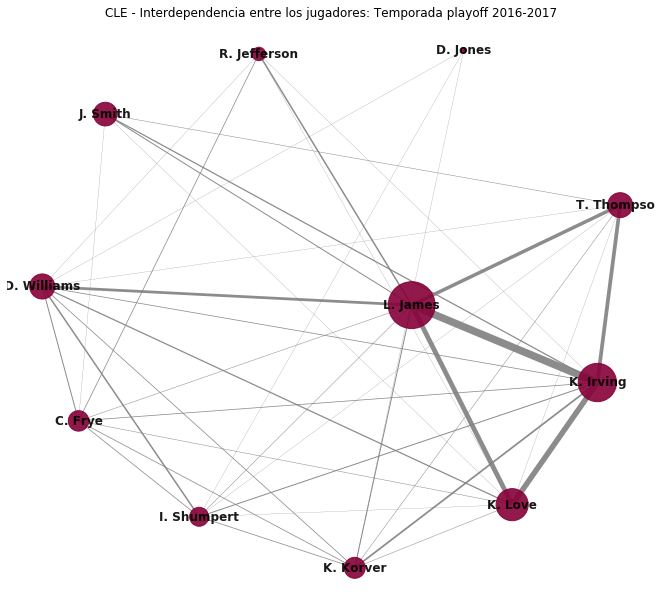

In [24]:
draw_network_all('CLE','2016-2017','playoff',df_involvement,df_pairs)

,Team,Degree,Closeness,Eigen,Betweennes,Pagerank
L. James,CLE,14,0.85,0.266698,0.00706442,0.172251
K. Irving,CLE,14,0.85,0.260438,0.0136242,0.163711
K. Love,CLE,12,0.772727,0.233145,0.0033731,0.0883998
T. Thompson,CLE,13,0.809524,0.250976,0.00499223,0.0883582
R. Jefferson,CLE,17,1,0.286212,0.0921309,0.0729303
I. Shumpert,CLE,16,0.944444,0.281979,0.0504643,0.0601849
D. Williams,CLE,16,0.85,0.262024,0.0578517,0.0537754
K. Korver,CLE,13,0.809524,0.250976,0.00499223,0.0428904
K. Felder,CLE,13,0.809524,0.244128,0.0106013,0.0404972
C. Frye,CLE,14,0.85,0.266698,0.00706442,0.0375241


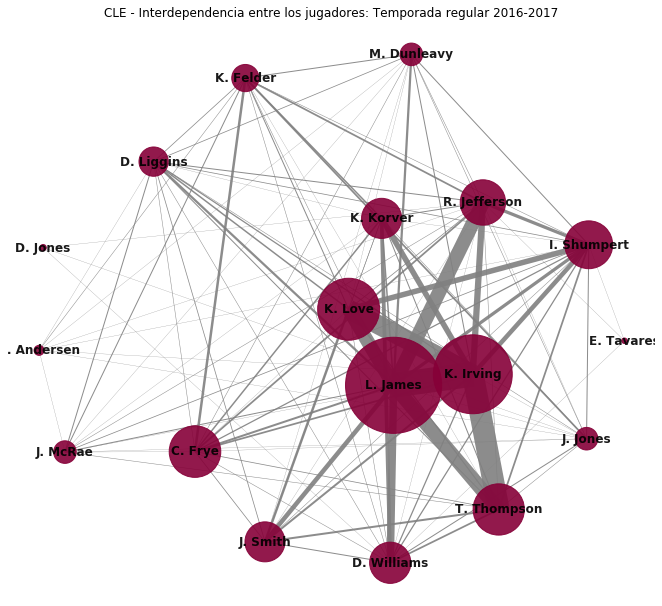

In [25]:
draw_network_all('CLE','2016-2017','regular',df_involvement,df_pairs)

,Team,Degree,Closeness,Eigen,Betweennes,Pagerank
L. James,CLE,11,0.923077,0.337863,0.0324435,0.211236
K. Love,CLE,9,0.8,0.29452,0.00769601,0.107906
G. Hill,CLE,8,0.75,0.270055,0.003367,0.0884579
T. Thompson,CLE,9,0.8,0.28369,0.020659,0.0838076
J. Green,CLE,11,0.923077,0.337863,0.0324435,0.0814511
J. Smith,CLE,9,0.8,0.286615,0.0161135,0.0775999
L. Nance,CLE,10,0.857143,0.309823,0.0282347,0.0749767
R. Hood,CLE,11,0.923077,0.318251,0.0883357,0.0724575
K. Korver,CLE,9,0.8,0.293606,0.0109428,0.0689209
J. Clarkson,CLE,8,0.75,0.247525,0.0412458,0.0513992


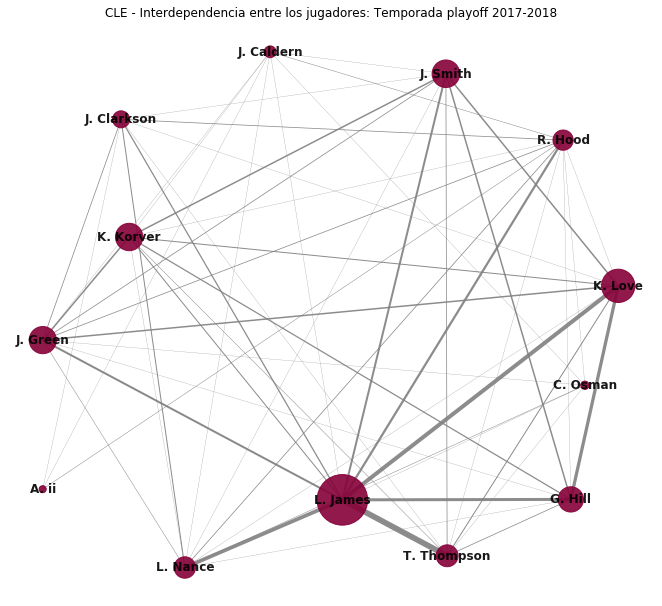

In [26]:
draw_network_all('CLE','2017-2018','playoff',df_involvement,df_pairs)

,Team,Degree,Closeness,Eigen,Betweennes,Pagerank
L. James,CLE,19,0.913043,0.280829,0.0417237,0.161491
K. Love,CLE,17,0.807692,0.26095,0.0210151,0.0829641
D. Wade,CLE,13,0.724138,0.204029,0.0126891,0.0771764
K. Korver,CLE,19,0.913043,0.276386,0.0537475,0.0742882
J. Smith,CLE,18,0.875,0.271582,0.0327158,0.0742627
J. Green,CLE,20,0.954545,0.285633,0.0643427,0.0711195
J. Caldern,CLE,18,0.875,0.26267,0.0472207,0.0595814
T. Thompson,CLE,16,0.777778,0.247411,0.0202307,0.0447801
J. Crowder,CLE,12,0.677419,0.193353,0.00306878,0.0431844
L. Nance,CLE,11,0.65625,0.182135,0.00218254,0.0370923


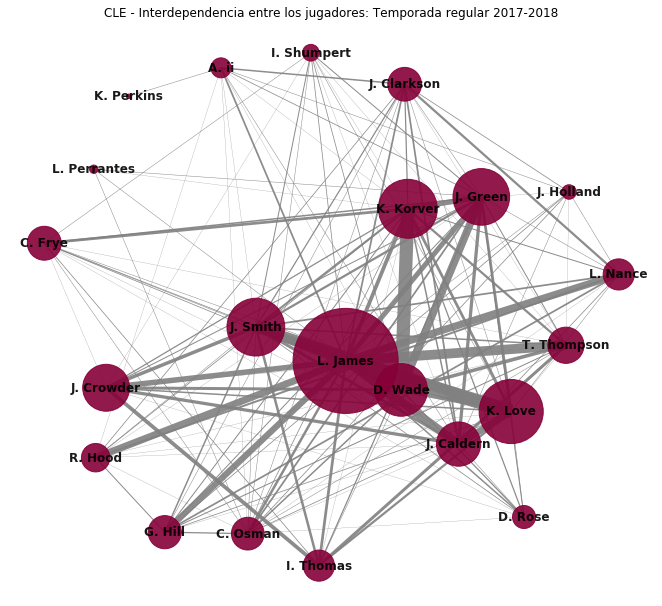

In [27]:
draw_network_all('CLE','2017-2018','regular',df_involvement,df_pairs)

,Team,Degree,Closeness,Eigen,Betweennes,Pagerank
C. Sexton,CLE,21,0.888889,0.27461,0.0452149,0.116132
C. Osman,CLE,21,0.888889,0.270849,0.0497686,0.108197
L. Nance,CLE,21,0.888889,0.269782,0.0511442,0.102787
J. Clarkson,CLE,23,0.96,0.289418,0.0650949,0.0994364
A. Burks,CLE,15,0.727273,0.204198,0.0619006,0.0573795
T. Thompson,CLE,18,0.8,0.240043,0.0299215,0.0556826
R. Hood,CLE,18,0.8,0.243002,0.0262306,0.0536829
K. Love,CLE,13,0.666667,0.195181,0.00558457,0.0392851
A. Zizic,CLE,17,0.774194,0.229191,0.0255636,0.0389702
B. Knight,CLE,13,0.666667,0.190448,0.00523781,0.0359749


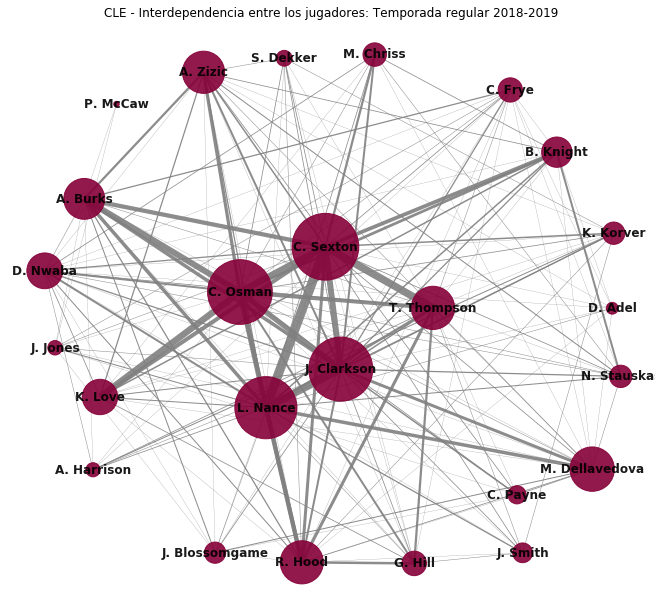

In [28]:
draw_network_all('CLE','2018-2019','regular',df_involvement,df_pairs) #no hay playoffs en 18-19

,Team,Degree,Closeness,Eigen,Betweennes,Pagerank
D. Green,GSW,11,0.866667,0.330622,0.0349512,0.178652
K. Durant,GSW,10,0.8125,0.312051,0.0178571,0.132152
S. Curry,GSW,11,0.866667,0.330622,0.0349512,0.110436
K. Thompson,GSW,10,0.8125,0.312051,0.0178571,0.0921834
A. Iguodala,GSW,11,0.866667,0.330622,0.0349512,0.0862687
D. West,GSW,9,0.764706,0.282762,0.0173077,0.081098
I. Clark,GSW,10,0.8125,0.295436,0.0463675,0.0594141
J. McGee,GSW,7,0.684211,0.235183,0.00160256,0.0516569
Z. Pachulia,GSW,6,0.619048,0.20733,0,0.0461269
S. Livingston,GSW,9,0.764706,0.267584,0.0328144,0.0457093


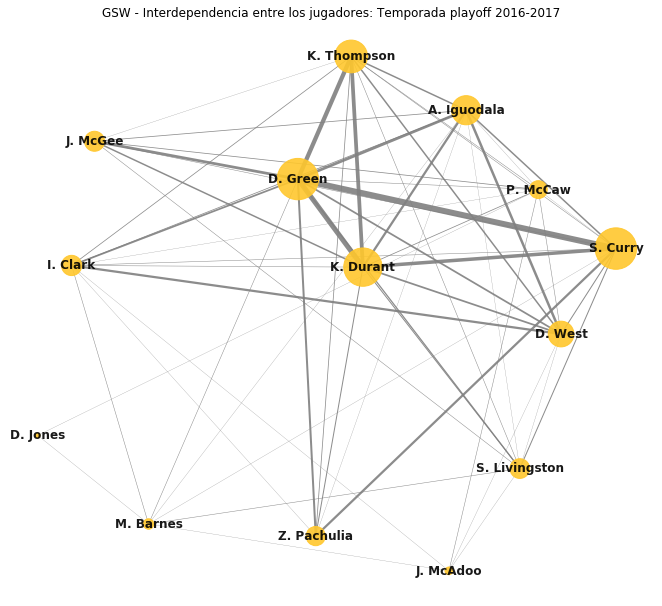

In [29]:
draw_network_all('GSW','2016-2017','playoff',df_involvement,df_pairs)

,Team,Degree,Closeness,Eigen,Betweennes,Pagerank
D. Green,GSW,13,0.842105,0.264645,0.00304293,0.164655
K. Thompson,GSW,13,0.842105,0.264645,0.00304293,0.124297
S. Curry,GSW,14,0.888889,0.273956,0.0144318,0.121463
K. Durant,GSW,13,0.842105,0.256215,0.0120707,0.112254
A. Iguodala,GSW,14,0.888889,0.270972,0.0238763,0.0913454
I. Clark,GSW,16,1,0.286516,0.0651263,0.0603114
D. West,GSW,11,0.761905,0.229728,0.000694444,0.058082
Z. Pachulia,GSW,12,0.8,0.248056,0.00145202,0.0474211
P. McCaw,GSW,16,1,0.286516,0.0651263,0.0432738
J. McGee,GSW,11,0.761905,0.230215,0.000694444,0.0381294


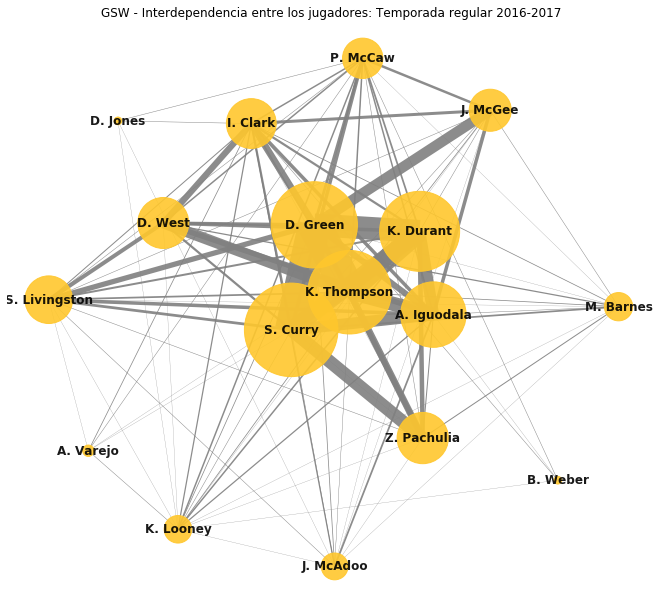

In [30]:
draw_network_all('GSW','2016-2017','regular',df_involvement,df_pairs)

,Team,Degree,Closeness,Eigen,Betweennes,Pagerank
R. Westbrook,OKC,17,0.947368,0.287031,0.0920064,0.233993
V. Oladipo,OKC,17,0.947368,0.294512,0.0478966,0.130844
S. Adams,OKC,13,0.782609,0.250832,0.00787685,0.114029
E. Kanter,OKC,15,0.857143,0.275132,0.0227254,0.0538428
D. Sabonis,OKC,13,0.782609,0.251166,0.00853045,0.0514901
S. Christon,OKC,16,0.9,0.274242,0.0782213,0.047563
A. Roberson,OKC,14,0.818182,0.260862,0.0185704,0.047349
J. Lauvergne,OKC,12,0.75,0.232467,0.00776014,0.0440891
J. Grant,OKC,17,0.947368,0.294512,0.0478966,0.0422013
T. Gibson,OKC,9,0.666667,0.187788,0,0.036799


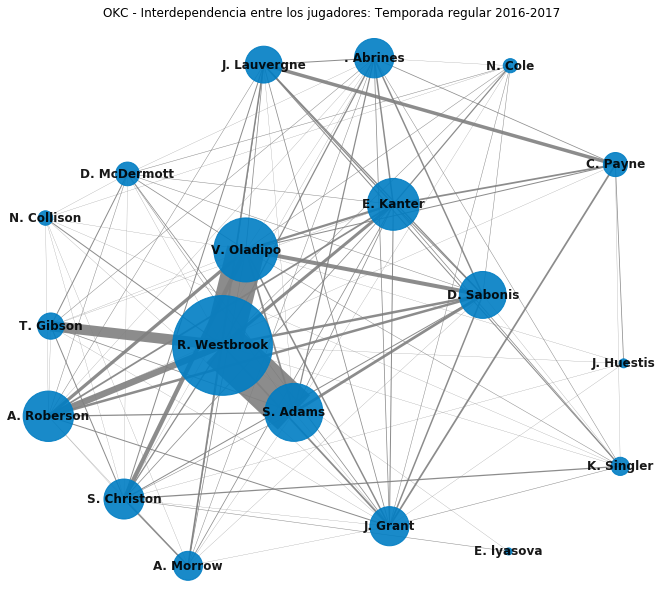

In [31]:
draw_network_all('OKC','2016-2017','regular',df_involvement,df_pairs)

,Team,Degree,Closeness,Eigen,Betweennes,Pagerank
R. Westbrook,OKC,8,0.833333,0.417704,0.144444,0.262541
V. Oladipo,OKC,7,0.714286,0.374727,0.0722222,0.106717
J. Grant,OKC,7,0.769231,0.387613,0.0814815,0.102335
S. Adams,OKC,4,0.625,0.250123,0.0222222,0.0973984
T. Gibson,OKC,3,0.555556,0.200693,0,0.0900347
A. Roberson,OKC,7,0.714286,0.368274,0.0851852,0.0884162
. Abrines,OKC,6,0.714286,0.285875,0.227778,0.0693052
D. McDermott,OKC,4,0.625,0.252352,0.0111111,0.0620364
E. Kanter,OKC,5,0.666667,0.296122,0.0388889,0.0532966
S. Christon,OKC,4,0.588235,0.246692,0.00555556,0.0469203


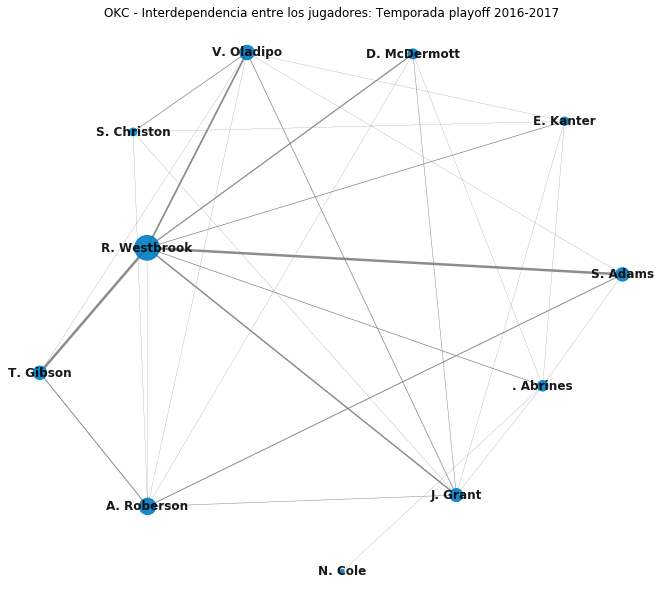

In [32]:
draw_network_all('OKC','2016-2017','playoff',df_involvement,df_pairs)